<a href="https://colab.research.google.com/github/julurisaichandu/data_analysis_gutenberg/blob/main/final_analysis1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of the Role of Information Revelation in the Popularity of English-Language Fiction Books

In this notebook we analyze the relationship between information revelation and the popularity of English-language fiction books. The analysis involves data preprocessing, feature extraction, exploratory data analysis, and regression modeling using various techniques.

## Part 1: Data Preprocessing and Cleaning

We start by loading and cleaning the metadata, KLD scores, and extra control variables.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import MultiLabelBinarizer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [ ]:
# Load data
meta = pd.read_csv('SPGC-metadata-2018-07-18.csv')
KLDscores = pd.read_csv('KLDscores.csv')
extraControls = pd.read_csv('extra_controls.csv')

def clean_metadata(meta):
    """
    Clean the metadata by filtering and processing relevant columns.
    """
    # Filter metadata to keep records with valid author birth/death years and download counts
    meta = meta[(meta["authoryearofbirth"] > 0) & (meta["authoryearofdeath"] > 0) & (meta["downloads"] > 0)].copy()

    # Replace empty language entries with NaN and drop them
    meta['language'] = meta['language'].replace('', np.nan)
    meta.dropna(subset=['language'], inplace=True)

    # Convert language entries from string representation of lists to actual lists
    meta['language'] = meta['language'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # One-hot encode the 'language' column
    mlb = MultiLabelBinarizer()
    one_hot_encoded = mlb.fit_transform(meta['language'])
    one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_, index=meta.index)
    meta = pd.concat([meta, one_hot_encoded_df], axis=1)

    # One-hot encode the 'type' column
    meta_encoded = pd.get_dummies(meta, columns=['type'])

    # Drop unnecessary columns
    return meta_encoded.drop(['title', 'author', 'subjects', 'language'], axis=1)

def process_kld_scores(KLDscores):
    """
    Calculate various KLD measures from the KLD scores.
    """
    def calculate_measures(kld_values):
        kld_values = np.array(kld_values)
        return pd.Series({
            'mean': np.mean(kld_values),
            'variance': np.var(kld_values),
            'slope': np.polyfit(range(len(kld_values)), kld_values, 1)[0],
            'peak_kld': np.max(kld_values),
            'peak_location': np.argmax(kld_values) / len(kld_values),
            'kld_std_dev': np.std(kld_values),
            'initial_final_kld_diff': np.mean(kld_values[-5:]) - np.mean(kld_values[:5]),
            'smoothness': np.mean(np.abs(np.diff(kld_values)))
        })

    # Convert the string representation of KLD values to actual lists
    KLDscores["kld_list"] = KLDscores['kld_values'].apply(lambda x: np.fromstring(x.strip("[]"), sep=','))

    # Calculate KLD measures
    df_measures = KLDscores.kld_list.apply(calculate_measures)

    return pd.concat([KLDscores[['filename']], df_measures], axis=1).rename(columns={'filename': 'id'})

def process_extra_controls(extraControls):
    """
    Impute missing values in extra control variables.
    """
    # Determine the genre with the highest value for each record. Used for finding the genre for a particular example
    extraControls['genre'] = extraControls[['subj2_war', 'subj2_adventure', 'subj2_comedy', 'subj2_biography', 'subj2_romance',
                      'subj2_drama', 'subj2_fantasy', 'subj2_family', 'subj2_sciencefiction', 'subj2_action',
                      'subj2_thriller', 'subj2_western', 'subj2_horror', 'subj2_mystery', 'subj2_crime',
                      'subj2_history', 'subj2_periodicals', 'subj2_others']].idxmax(axis=1)

    # Impute missing values based on the mean of each genre group
    cols_to_impute = ['speed', 'sentiment_avg', 'sentiment_vol', 'wordcount']
    extraControls[cols_to_impute] = extraControls.groupby('genre')[cols_to_impute].transform(lambda x: x.fillna(x.mean()))

    # renaming each feature
    return extraControls.drop("genre", axis=1).rename(columns={'subj2_war':'war', 'subj2_adventure':'adventure',
                                                               'subj2_comedy':'comedy', 'subj2_biography':'biography',
                                                               'subj2_romance':'romance','subj2_drama':'drama',
                                                               'subj2_fantasy':'fantasy', 'subj2_family':'family',
                                                               'subj2_sciencefiction':'sciencefiction', 'subj2_action':'action',
                                                               'subj2_thriller':'thriller', 'subj2_western':'western',
                                                               'subj2_horror':'horror', 'subj2_mystery':'mystery', 'subj2_crime':'crime',
                                                               'subj2_history':'history', 'subj2_periodicals':'periodicals',
                                                               'subj2_others':'others'})

# Process datasets
meta_cleaned = clean_metadata(meta)
kld_processed = process_kld_scores(KLDscores)
extraControls_processed = process_extra_controls(extraControls)

# Merge datasets
merged_data_kld_meta = pd.merge(meta_cleaned, kld_processed, on='id', how='inner')
merged_data_all = pd.merge(merged_data_kld_meta, extraControls_processed, on='id', how='inner')

# Remove constant columns because there is no use if there is only single unique value for each feature
merged_data_kld_meta = merged_data_kld_meta.loc[:, (merged_data_kld_meta != merged_data_kld_meta.iloc[0]).any()]


In [ ]:
###################### Features list #########################

kld_features = ['mean', 'variance', 'slope', 'peak_kld', 'peak_location', 'kld_std_dev', 'initial_final_kld_diff', 'smoothness']
control_features_continuous = ['authoryearofbirth', 'authoryearofdeath']
control_features_catagorical = ['cy', 'el', 'en', 'enm', 'eo', 'es', 'fr', 'kha', 'la', 'tl', 'zh']
extra_features_catagorical = ['war', 'adventure', 'comedy', 'biography', 'romance','drama', 'fantasy', 'family', 'sciencefiction', 'action','thriller', 'western', 'horror', 'mystery', 'crime','history', 'periodicals', 'others']
extra_features_continuous = ['speed', 'sentiment_avg', 'sentiment_vol', 'wordcount']

## Part 2: Exploratory Data Analysis

We will visualize the correlation between different features and explore the relationship between KLD measures and downloads.


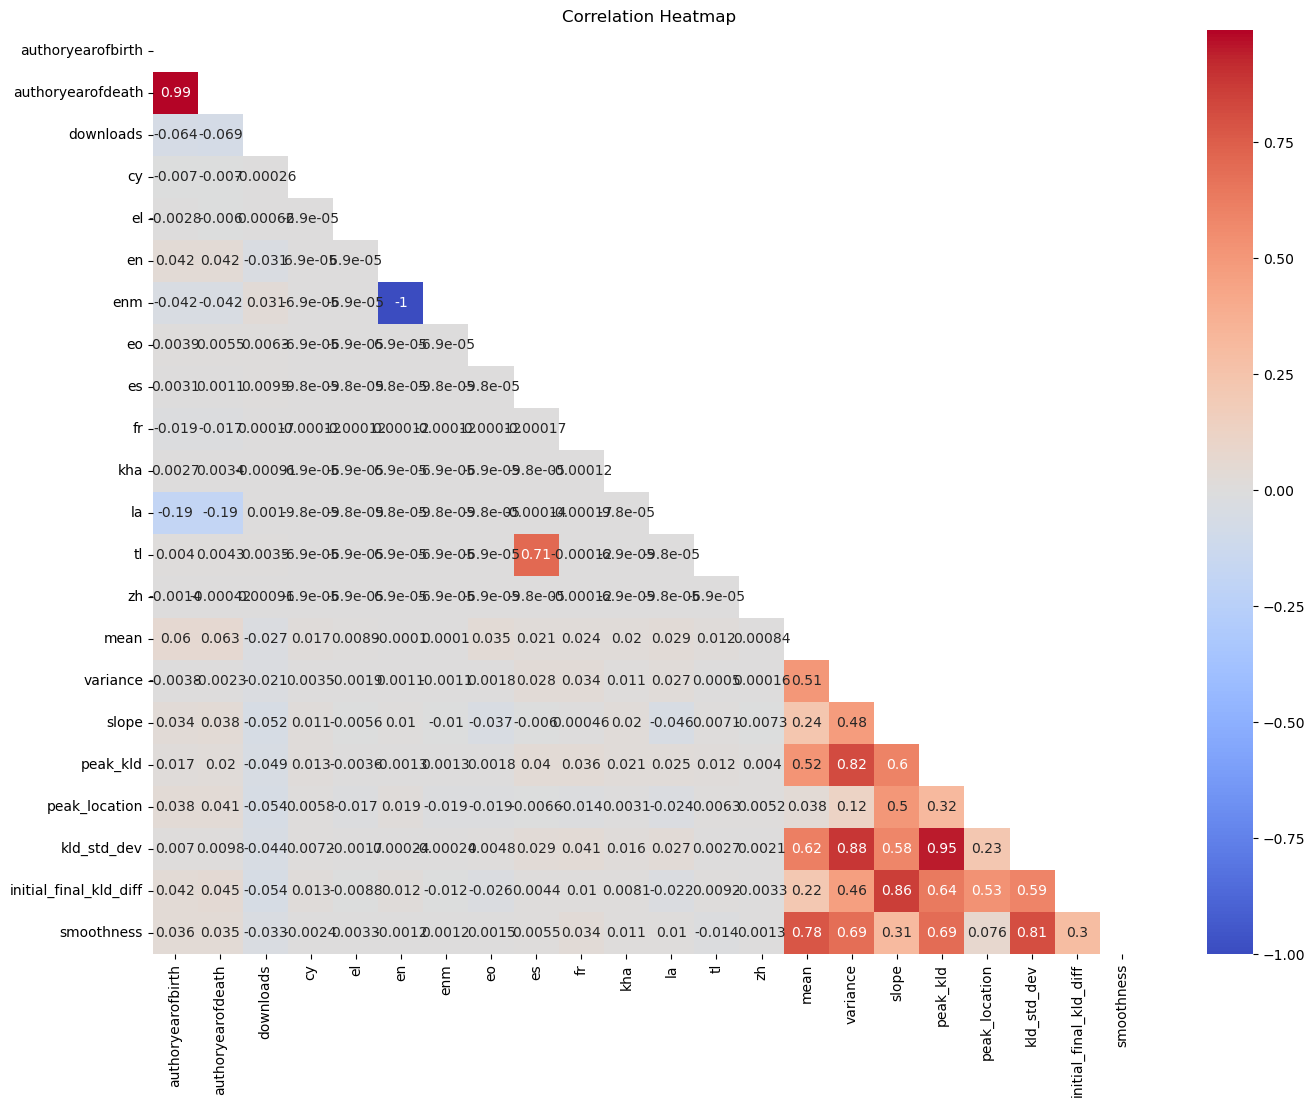

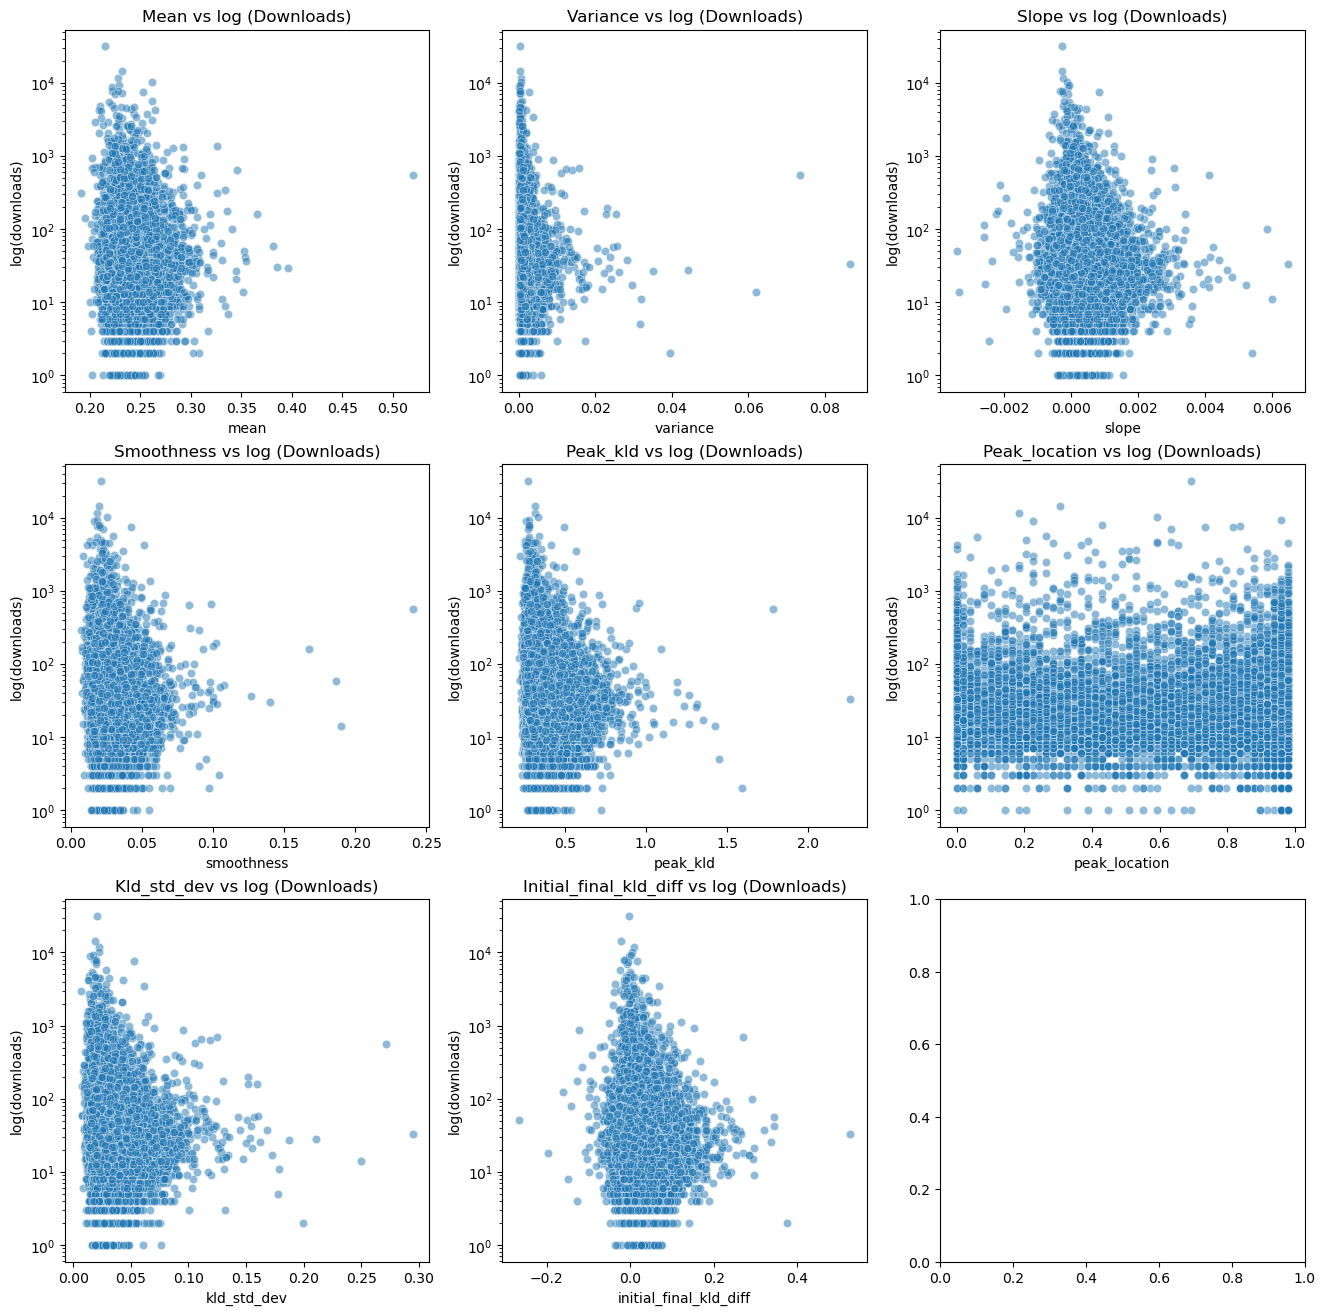

In [ ]:
def plot_correlations(data):
    """
    Plot a correlation heatmap for the given data.
    """
    plt.figure(figsize=(16, 12))
    mask = np.triu(np.ones_like(data.corr(), dtype=bool))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', mask=mask)
    plt.title('Correlation Heatmap')
    plt.show()

def plot_kld_vs_downloads(data):
    """
    Plot scatter plots to visualize the relationship between KLD measures and downloads.
    """
    fig, axes = plt.subplots(3, 3, figsize=(16, 16))
    axes = axes.ravel()
    for i, col in enumerate(['mean', 'variance', 'slope', 'smoothness', 'peak_kld', 'peak_location', 'kld_std_dev', 'initial_final_kld_diff']):
        sns.scatterplot(x=col, y='downloads', data=data, ax=axes[i], alpha=0.5)
        axes[i].set_yscale('log')
        axes[i].set_title(f'{col.capitalize()} vs log (Downloads)')
        axes[i].set(ylabel='log(downloads)')
    plt.show()

# Plot correlation heatmap
plot_correlations(merged_data_kld_meta)

plot_kld_vs_downloads(merged_data_kld_meta)


<span style="background:yellow"> Before doing regression analysis, we could see form the above plots that there are outliers in the data </span>

<span style="background:yellow"> From the correlation matrix, we can see that the columns from the KLD table are the most correlated in the merged data frame with meta, so we will use VIF calculation on those columns for eliminating the collinear columns</span>


## VIF calculation for fetaure elimination

In [ ]:
# Removing features with VIF>=5 for avoiding collinearity


def compute_vif(data, features):
    X = data[features].copy()
    X['intercept'] = 1

    vif = pd.DataFrame()
    vif["Variable"] = features
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(features))]

    return vif

def remove_collinear_features(data, features, threshold=5):
    while True:
        vif_df = compute_vif(data, features)
        max_vif = vif_df['VIF'].max()

        if max_vif < threshold:
            break

        max_vif_variable = vif_df.loc[vif_df['VIF'] == max_vif, 'Variable'].iloc[0]
        print(f"Removing {max_vif_variable} with VIF {max_vif}")
        features.remove(max_vif_variable)

    return vif_df


kld_features_non_collinear = remove_collinear_features(merged_data_kld_meta, kld_features).Variable.tolist()

print('VIF<5 features which should be considered\n', kld_features_non_collinear)

Removing kld_std_dev with VIF 28.582792506655576
VIF<5 features which should be considered
 ['mean', 'variance', 'slope', 'peak_kld', 'peak_location', 'initial_final_kld_diff', 'smoothness']


## Removing Outliers from meta and KLD

In [ ]:
# Removing the outliers from the merged data frame
def calc_z_scores(cols_lst):
    """
    Calculate Z-scores for the given columns and remove outliers.
    """
    z_scores = np.abs(stats.zscore(merged_data_kld_meta[cols_lst]))
    mask = (z_scores < 3).all(axis=1)
    df_no_outliers = merged_data_kld_meta[mask]
    return df_no_outliers

############## meta and kld merged dataframe without any outliers and non collinear features  ###################
df_no_outliers = calc_z_scores(control_features_continuous + kld_features_non_collinear)


## Part 3: Regression Analysis

### Ordinary Least Squares (OLS) Regression

We will first run an OLS regression to understand the relationship between KLD measures and log(downloads).


In [ ]:
def run_ols_regression(X, y):
    """
    method to run the OLS regression and return the model
    """
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model

# By running the OLS model, we have considered only these features by shortlisting from the P values.
all_features =['mean', 'variance',  'peak_kld', 'peak_location', 'initial_final_kld_diff','smoothness', 'authoryearofbirth','tl']

# Merge KLD features and control features
# all_features = kld_features_non_collinear + control_features_continuous + control_features_catagorical
X_features = all_features[:]

X = df_no_outliers[all_features]
y = np.log(df_no_outliers['downloads'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run OLS regression
ols_model = run_ols_regression(X_scaled, y)
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:              downloads   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     48.36
Date:                Tue, 02 Jul 2024   Prob (F-statistic):           1.60e-77
Time:                        22:59:54   Log-Likelihood:                -21199.
No. Observations:               13793   AIC:                         4.242e+04
Df Residuals:                   13784   BIC:                         4.248e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1932      0.010    333.166      0.0

- After running OLS regression, we are unable to find any relation of features with the log (downloads).
- However, by seeing the results, we can get info that some features are negatively impacting the popularity and some have positive impact

<span style="background:yellow"> We are going to employ another method "Lasso Regression" in the next sestion for finding relation of the features with the popularity. </span>


### LASSO Regression

Next, we will use LASSO regression to identify the most important features.


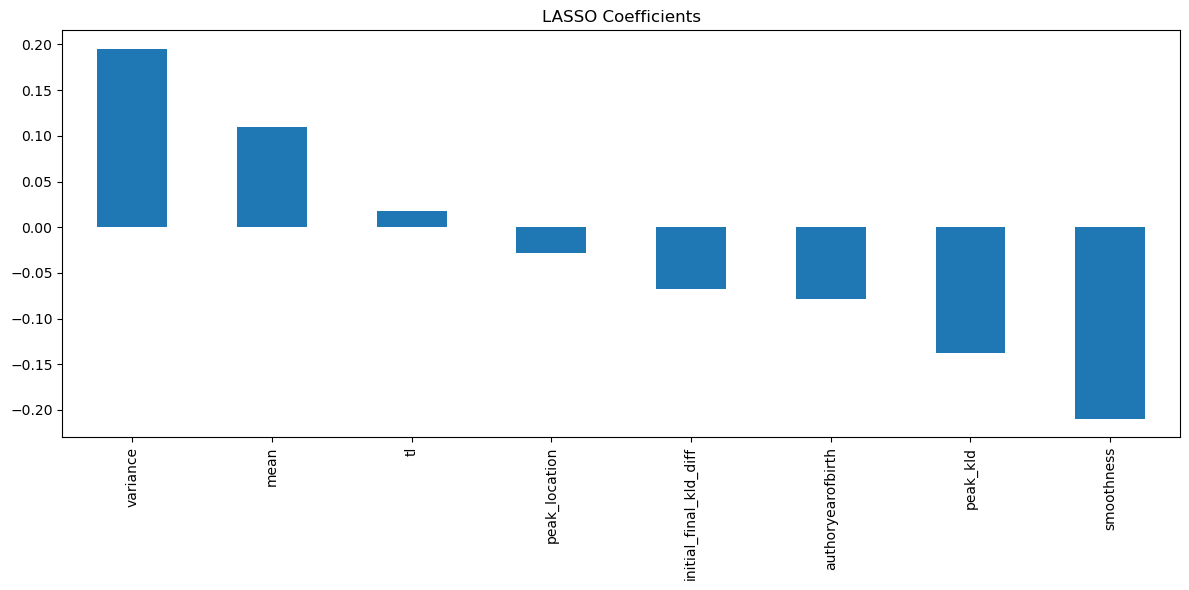

lasso coefficients
 variance                  0.195246
mean                      0.110218
tl                        0.017259
peak_location            -0.028653
initial_final_kld_diff   -0.067865
authoryearofbirth        -0.078482
peak_kld                 -0.137559
smoothness               -0.209522
dtype: float64


In [ ]:
def run_lasso_regression(X, y):
    """
    Method to run LASSO regression and return the model and the scaler.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    lasso = LassoCV(cv=5, random_state=0)
    lasso.fit(X_scaled, y)
    return lasso, scaler

# all_features = [col for col in merged_data_all.columns if col not in ['id', 'downloads']]
X_all = df_no_outliers[all_features]
y = np.log(df_no_outliers['downloads'])

# Run LASSO regression
lasso_model, scaler = run_lasso_regression(X_all, y)

# Extract and plot LASSO coefficients
lasso_coefficients = pd.Series(lasso_model.coef_, index=all_features)
lasso_coefficients = lasso_coefficients[lasso_coefficients != 0].sort_values(ascending=False)
plt.figure(figsize=(12, 6))
lasso_coefficients.plot(kind='bar')
plt.title('LASSO Coefficients')
plt.tight_layout()
plt.show()
print('lasso coefficients\n',lasso_coefficients)

1. Variance and mean KLD have a positive influence on the target.
2. Smoothness and the author's year of birth have strong negative influences.
3. KLD-related features (peak KLD, peak location, initial_final_kld_diff) have relatively smaller influences, all negative.
4. The model suggests that all these features contribute to the prediction.

<span style="background:yellow"> *We will explore OLS polynomial regression in the next section to see if we can get any insights *</span>


### Polynomial Regression

We will also explore polynomial regression to capture potential non-linear relationships.


In [ ]:
X = df_no_outliers[kld_features_non_collinear]

# Transform features using PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

y = np.log(df_no_outliers['downloads'])

# Standardize the polynomial features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

# Run OLS regression on polynomial features
ols_model_poly = run_ols_regression(X_scaled, y)
print(ols_model_poly.summary())


                            OLS Regression Results                            
Dep. Variable:              downloads   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     12.14
Date:                Tue, 02 Jul 2024   Prob (F-statistic):           2.59e-67
Time:                        22:59:55   Log-Likelihood:                -21180.
No. Observations:               13793   AIC:                         4.243e+04
Df Residuals:                   13757   BIC:                         4.270e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1932      0.010    333.296      0.0

<span style="background:yellow"> *When we tried the polynomial regression as well, we didnt get any important relation between the kld features and the log(downloads)*</span>

## Part 5: Investigating Heterogeneity of Effects Across Genres

We will investigate the heterogeneity of effects across genres and use LASSO regression to identify the most independently predictive variables for log(downloads) in each genre.


Genre: others
peak_location            -0.013816
initial_final_kld_diff   -0.037418
smoothness               -0.061315
peak_kld                 -0.062105
authoryearofbirth        -0.084721
dtype: float64


Genre: romance
variance                  0.439538
mean                     -0.055457
initial_final_kld_diff   -0.087431
smoothness               -0.252597
peak_location            -0.308734
peak_kld                 -0.335453
authoryearofbirth        -0.539580
dtype: float64


Genre: adventure
smoothness               -0.017965
variance                 -0.024478
authoryearofbirth        -0.055253
mean                     -0.150353
initial_final_kld_diff   -0.153943
peak_location            -0.170565
dtype: float64


Genre: sciencefiction
authoryearofbirth    2.450147e-17
dtype: float64


Genre: history
smoothness          -0.037890
peak_kld            -0.038019
peak_location       -0.050912
authoryearofbirth   -0.061513
dtype: float64


Genre: fantasy
initial_final_kld_diff   -0.09830

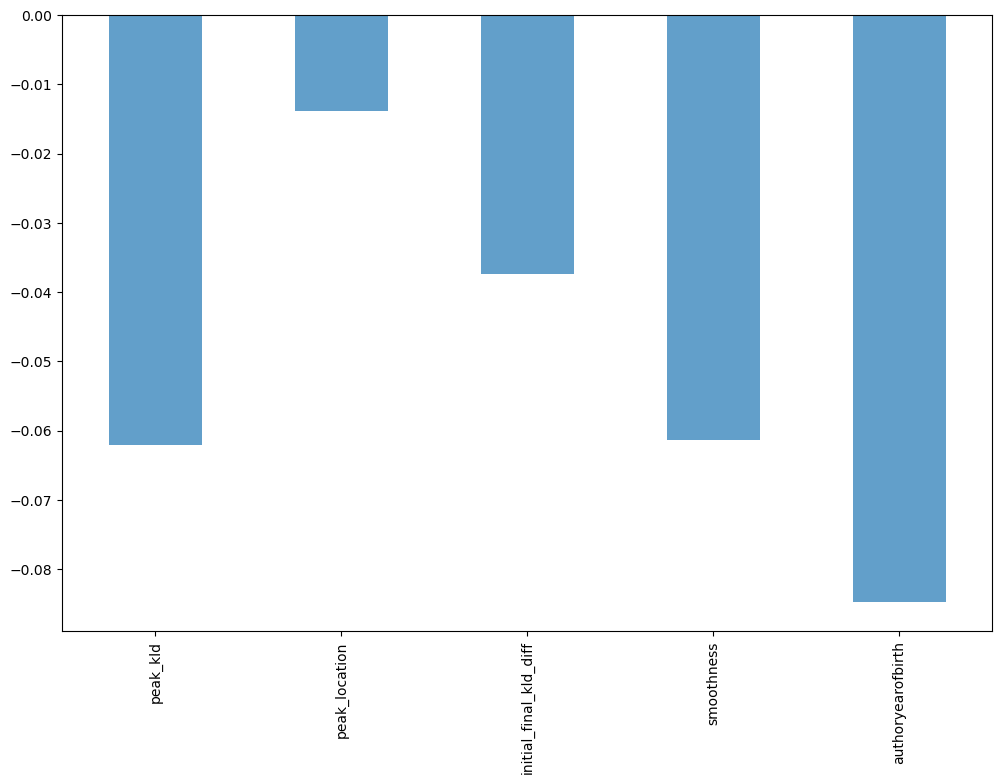

In [ ]:
# Define a function to run LASSO regression and extract coefficients for a given subset of data
def run_genre_lasso(X, y):
    """
    Run LASSO regression for a given genre and return the non-zero coefficients.
    """
    lasso = LassoCV(cv=5, random_state=0, max_iter=10000)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    lasso.fit(X_scaled, y)

    coefficients = pd.Series(lasso.coef_, index=X.columns)
    return coefficients[coefficients != 0]

all_features = ['mean', 'variance',  'peak_kld', 'peak_location', 'initial_final_kld_diff','smoothness', 'authoryearofbirth', 'tl']
# Add the genre column to the merged_data_all DataFrame
extraControls_processed['genre'] = extraControls_processed[extra_features_catagorical].idxmax(axis=1)
merged_data_all = pd.merge(df_no_outliers[all_features+['downloads', 'id']], extraControls_processed[['id', 'genre']], on='id')

# Dictionary to store LASSO coefficients for each genre
genre_coefficients = {}

# List of unique genres
genres = merged_data_all['genre'].unique()

# # LASSO regression for each genre
for genre in genres:
    genre_data = merged_data_all[merged_data_all['genre'] == genre]
    X_genre = genre_data[all_features]
    y_genre = np.log(genre_data['downloads'])

    genre_coefficients[genre] = run_genre_lasso(X_genre, y_genre)

# genre coefficients cna be empty series, so avoiding it
non_empty_coefficients = {genre: coef for genre, coef in genre_coefficients.items() if not coef.empty}

# # Display the coefficients for each genre
for genre, coefficients in non_empty_coefficients.items():
    if coefficients.empty:
        continue  # Skip empty series
    print(f"Genre: {genre}")
    print(coefficients.sort_values(ascending=False))
    print("\n")

# # Plotting the coefficients for each genre
fig, ax = plt.subplots(figsize=(12, 8))
for genre, coefficients in non_empty_coefficients.items():
    coefficients.plot(kind='bar', ax=ax, label=genre, alpha=0.7)
    plt.show()

ax.set_title('LASSO Coefficients by Genre')
ax.legend()

## Anslysis

In our data analysis, the relationship between book-level measures of <b>KLD like mean, variance, peak_kld, standard deviation, slope etc</b> and book popularity is measured by log(downloads), using multiple regression techniques. The <b>Ordinary Least Squares (OLS) linear regression model</b>, which is applied for kld and meta data frames (we have done some pre processing of data like <b>removing outliers, removing collinear features </b>etc.), explaines that the features collectively <b>cannot significantly predict the popularity</b> (R-squared = 0.027). Significant predictors included <b>smoothness and mean</b>. Similarly, the polynomial regression model showed a slight improvement in fit (R-squared = 0.030), indicating that while higher-order relationships might exist, however they are not significant enough to provide a strong predictive model. When we used Lasso for predicting the importance of each feature, <b>variance and mean</b> are positively contributing to the poplarity of the books.

The <b>LASSO</b> regression when done for the whole data set grouping each genre, for most genres, variables such as <b>"authoryearofbirth" and "smoothness" consistently showed negative coefficients, i.e., more weitage of these features contribute to lower downloads</b>. However, the results varied significantly between genres. For instance, in the romance genre, "variance" had a positive coefficient, whereas in the family genre, "mean" and "peak_kld" were negatively associated with downloads. <b>This heterogeneity highlights the complexity of predicting book popularity and suggests that genre-specific models might be necessary for more accurate predictions</b>.


| Model                  | How features are selected |
|--------------------------|-------------|
| OLS linear                 | Used meta+kld features and considered features where VIF<5 and OLS P scores<0.1    |
| OLS linear                     | same features as OLS Linear     |
| Lasso                       | same features as OLS Linear    |
| Lasso for each genres            | same features as OLS Linear with imputed features of the extra controls df   |

